<a href="https://colab.research.google.com/github/jarrydmartinx/generative-models/blob/master/Autoencoder_with_Sonnet_and_TensorFlow_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An Undercomplete Autoencoder with Sonnet with TensorFlow Datasets 
* Let's make an (undercomplete) autoencoder with Sonnet using TensorFlow Datasets

In [0]:
#@title Install
! pip install -q plotnine

In [0]:
#@title Imports

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotnine as gg
import sonnet as snt
import tensorflow as tf
import tensorflow_datasets as tfds
from collections import namedtuple


from typing import Text, List, Tuple


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



## Getting our Data using TensorFlow Datasets

Here's some friendly stuff about tfds

In [0]:
#@title Preparing our data

def get_data(dataset_name: Text, batch_size: int = 25) -> tf.Tensor:
  
  # This downloads and prepares the dataset, or retrieves it from the cache.
  dataset = tfds.load(dataset_name, split=tfds.Split.ALL)

  # Pipelining operations: repeat the dataset infinitely and batch it.
  dataset = dataset.repeat().batch(batch_size, drop_remainder=True)

  # Make an iterator: this iterates through the batches.
  iterator = dataset.make_one_shot_iterator()

  # Data op, when run in a tf.Session, spits out a batch of data.
  data = iterator.get_next()
  
  input_data = tf.cast(data['image'], dtype=tf.float32)

  return input_data

Instructions for updating:
Colocations handled automatically by placer.


W0502 20:51:54.932442 140091387574144 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/control_flow_ops.py:423: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


INFO:tensorflow:Graph was finalized.


I0502 20:51:55.014315 140091387574144 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0502 20:51:55.695707 140091387574144 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0502 20:51:55.702118 140091387574144 session_manager.py:493] Done running local_init_op.


Image batch shape: (25, 28, 28, 1)


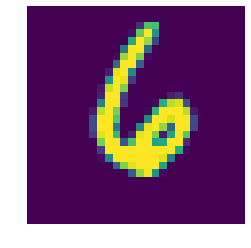

In [0]:
#@title Visualising our data

def show_img_sample(dataset_name: Text):

  # Get a batch of images
  data_op = get_data(dataset_name)
  with tf.train.MonitoredSession() as sess:
    batch = sess.run(data_op)
  
  # Print the shape of the batch of images
  print('Image batch shape: {}'.format(batch.shape))
  
  # Retrieve and show a sample image from the batch
  image = batch[0].squeeze(axis=-1)
  plt.imshow(image)
  plt.axis('off')
  plt.show()

show_img_sample('mnist')

## Making Models out of Sonnet modules


Here's some friendly stuff about Sonnet modules

Sequential takes a list of callables that are functions from tensors to tensors.
Think of Sequential as a scaffold to connect a bunch of pipes together. Each sonnet module is a pipe that alters the tensors flowing through it.

sequential(List[Callable[[tf.Tensor], tf.Tensor]])

From Conv2DTranspose: https://sonnet.dev/sonnet/#class-conv2dtranspose

output_shape: Output shape of transpose convolution. Can be either an iterable of integers or a callable. In the latter case, since the function invocation is deferred to graph construction time, the user must only ensure that output_shape can be called, returning an iterable of format (out_height, out_width) when build is called. Note that output_shape defines the size of output signal domain, as opposed to the shape of the output Tensor. If a None value is given, a default shape is automatically calculated (see docstring of _default_transpose_size function for more details).

In [0]:
#@title Models
def get_model(model_name: Text):
  
  conv_layers = snt.nets.ConvNet2D(output_channels=[16, 32, 64], 
                                      kernel_shapes=[3, 3, 3],
                                      strides=[2, 2, 1], 
                                      paddings=['SAME'])
  deconv_layers = conv_layers.transpose()
  
  models = {
      'mlp': snt.Sequential([
          snt.BatchFlatten(),
          snt.nets.MLP([50, 25, 10]),
          snt.nets.MLP([25, 50, 784]),
          lambda x: tf.reshape(x, shape=[25, 28, 28, 1]),
      ]),
      'conv': snt.Sequential([
          conv_layers,                       
          snt.BatchFlatten(),
          snt.nets.MLP([25, 10]),
          snt.nets.MLP([25, 392]),
          lambda x: tf.reshape(x, shape=[25, 7, 7, 8]),
          deconv_layers,
      ])
  }
  
  return models[model_name]

## Training our Models

In [0]:
# Make a container for a batch of true/reconst. images for each trained model
Reconstructions = namedtuple('Reconstructions', ['true_images', 'recon_images'])

 * All of the graph construction and calls to sess.run occur within this train function below

In [0]:
#@title Collecting our Results

# List the datasets and models we want to use
datasets = ['mnist', 'fashion_mnist']
models = ['mlp', 'conv']

# Train each autoencoder model on each dataset
results = pd.DataFrame()
images = {}

for dataset in datasets:
  images[dataset] = {}
  
  for model in models:
    print('Training {} model on {} dataset...'.format(model, dataset))
    
    result, recons = train_autoencoder(dataset, model, num_training_steps=2000)
    
    # Label the result by model and dataset and add it to our DataFrame
    result['model'] = model
    result['dataset'] = dataset
    results = pd.concat([results, result])
    
    # Store the true and reconstructed images
    images[dataset][model] = recons


In [0]:
#@title Our train function

def train_autoencoder(dataset_name: Text, 
                      model_name: Text,
                      num_training_steps: int = 1000,
                      batch_size: int = 25,
                      learning_rate: float = 1e-3,
                      log_every: int = 10) -> Tuple[pd.DataFrame, 
                                                    Reconstructions]:

  tf.reset_default_graph()

  model = get_model(model_name)

  input_data = get_data(dataset_name) 

  # Make the output op, which connects our model to the data ops defined earlier
  y = model(input_data)

  # Define a loss op. We're using mean squared reconstruction error.
  loss = tf.reduce_mean((input_data - y) ** 2)

  # Pick an optimizer. Adam is a popular choice and usually works well.
  optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

  # Create the stochastic gradient descent op. Computes and applies gradients.
  sgd_op = optimizer.minimize(loss)
  
  # Make and initialize a session so we can run our graph ops
  sess = tf.Session()
  sess.run(tf.global_variables_initializer())

  # Training Loop
  results = [] 
  for step in range(num_training_steps):
    sess.run(sgd_op)

    if step % log_every == 0:
      
      result = {
          'step': step,
          'loss': sess.run(loss),
      }
      results.append(result)
  
  # Collect a batch of true/reconst images using the trained model
  true_images, recons = sess.run([input_data, y])
  
  images = Reconstructions(true_images=true_images.squeeze(-1), 
                                  recon_images=recons.squeeze(-1))    
  
  sess.close()
  
  return pd.DataFrame(results), images                      
                      

## Plotting the Loss and Viewing the Reconstructed Images

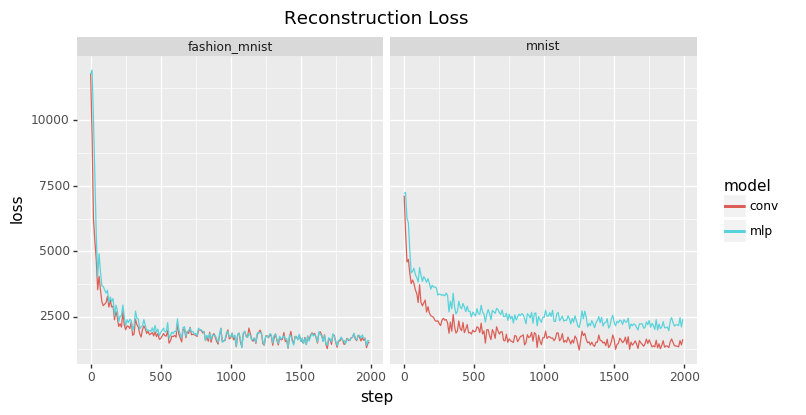

<ggplot: (8755565938664)>

In [0]:
#@title Plotting the Reconstruction Loss

#Plot our reconstruction loss results
p = (gg.ggplot(results)
     + gg.aes(x='step', y='loss', color='model')
     + gg.theme(figure_size = (8, 4))
     + gg.facet_wrap('dataset')
     + gg.geom_line()
     + gg.ggtitle('Reconstruction Loss')
    )

p

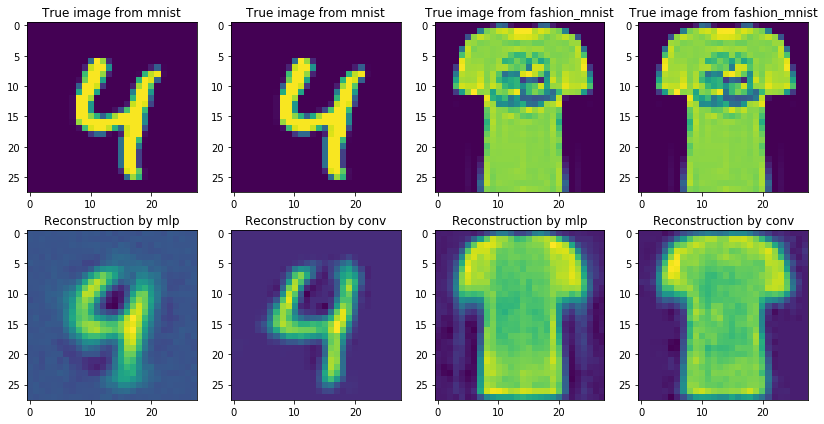

In [0]:
#@title Comparing the Reconstructed Images

# Make a figure with a (2 x (datasets * models)) subplot grid
num_combinations = len(datasets) * len(models)
f, axarr = plt.subplots(2, num_combinations)
f.set_figwidth(14)
f.set_figheight(7)

# Populate the figure with a true and reconst. image for each model and dataset
column = 0
rand_idx = np.random.randint(24)
for dataset in datasets:
  for model in models:
    axarr[0, column].imshow(images[dataset][model].true_images[rand_idx])
    axarr[0, column].set_title('True image from {}'.format(dataset))
    axarr[1, column].imshow(images[dataset][model].recon_images[rand_idx])
    axarr[1, column].set_title('Reconstruction by {}'.format(model))
    column += 1